In [ ]:
# 1) Verify the file is in /content
!ls -lh /content | head -n 20

# 2) Create Kaggle config folder and move the key there
!mkdir -p /root/.kaggle
!cp /content/kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

# 3) Verify Kaggle can see it
!ls -lh /root/.kaggle
!python -c "import kaggle; print('Kaggle auth OK')"


total 12K
-rw-r--r-- 1 root root   69 Jan  3 23:40 kaggle.json
drwxr-xr-x 2 root root 4.0K Jan  3 23:40 m5
drwxr-xr-x 1 root root 4.0K Dec 11 14:34 sample_data
total 4.0K
-rw------- 1 root root 69 Jan  3 23:40 kaggle.json
Kaggle auth OK


In [ ]:
!mkdir -p /content/m5
!kaggle competitions download -c m5-forecasting-accuracy -p /content/m5
!ls -lh /content/m5


  0% 0.00/45.8M [00:00<?, ?B/s]
100% 45.8M/45.8M [00:00<00:00, 2.11GB/s]
total 46M
-rw-r--r-- 1 root root 46M Jun  1  2020 m5-forecasting-accuracy.zip


In [ ]:
import zipfile

with zipfile.ZipFile("/content/m5/m5-forecasting-accuracy.zip", "r") as z:
    z.extractall("/content/m5")

!ls /content/m5


calendar.csv		     sales_train_evaluation.csv  sample_submission.csv
m5-forecasting-accuracy.zip  sales_train_validation.csv  sell_prices.csv


In [ ]:
import pandas as pd

calendar = pd.read_csv("/content/m5/calendar.csv")
sales = pd.read_csv("/content/m5/sales_train_validation.csv")
prices = pd.read_csv("/content/m5/sell_prices.csv")
sample_sub = pd.read_csv("/content/m5/sample_submission.csv")

print(calendar.shape)
print(sales.shape)
print(prices.shape)
print(sample_sub.shape)


(1969, 14)
(30490, 1919)
(6841121, 4)
(60980, 29)


In [20]:
sales.loc[0, ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"]]


,0
id,HOBBIES_1_001_CA_1_validation
item_id,HOBBIES_1_001
dept_id,HOBBIES_1
cat_id,HOBBIES
store_id,CA_1
state_id,CA


In [21]:
d_cols = [c for c in sales.columns if c.startswith("d_")]
print("First day:", d_cols[0])
print("Last day:", d_cols[-1])
print("Number of sales days:", len(d_cols))


First day: d_1
Last day: d_1913
Number of sales days: 1913


In [22]:
print("Calendar days:", calendar["d"].nunique())
print("Calendar range:", calendar["d"].min(), "to", calendar["d"].max())

calendar.head(3)


Calendar days: 1969
Calendar range: d_1 to d_999


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0


In [23]:
ITEM_ID = sales["item_id"].iloc[0]      # simple fixed choice
item_sales = sales[sales["item_id"] == ITEM_ID].copy()

print("Chosen ITEM_ID:", ITEM_ID)
print("Rows (stores) for this item:", item_sales.shape[0])
item_sales[["store_id", "state_id"]].head(10)


Chosen ITEM_ID: HOBBIES_1_001
Rows (stores) for this item: 10


,store_id,state_id
0,CA_1,CA
3049,CA_2,CA
6098,CA_3,CA
9147,CA_4,CA
12196,TX_1,TX
15245,TX_2,TX
18294,TX_3,TX
21343,WI_1,WI
24392,WI_2,WI
27441,WI_3,WI


In [24]:
# Identify sales columns
d_cols = [c for c in item_sales.columns if c.startswith("d_")]

# Convert to long format
item_long = item_sales.melt(
    id_vars=["store_id"],
    value_vars=d_cols,
    var_name="d",
    value_name="sales"
)

item_long.head()


,store_id,d,sales
0,CA_1,d_1,0
1,CA_2,d_1,0
2,CA_3,d_1,0
3,CA_4,d_1,0
4,TX_1,d_1,0


In [25]:
item_long = item_long.merge(
    calendar[["d", "date", "weekday", "month", "year"]],
    on="d",
    how="left"
)

item_long.head()


,store_id,d,sales,date,weekday,month,year
0,CA_1,d_1,0,2011-01-29,Saturday,1,2011
1,CA_2,d_1,0,2011-01-29,Saturday,1,2011
2,CA_3,d_1,0,2011-01-29,Saturday,1,2011
3,CA_4,d_1,0,2011-01-29,Saturday,1,2011
4,TX_1,d_1,0,2011-01-29,Saturday,1,2011


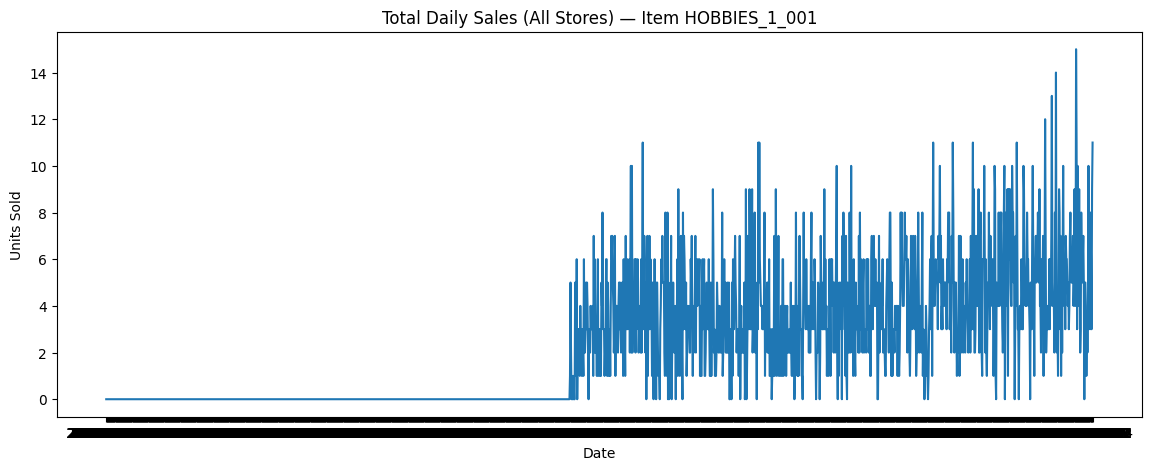

In [26]:
total_sales = (
    item_long
    .groupby("date")["sales"]
    .sum()
)

plt.figure(figsize=(14,5))
plt.plot(total_sales.index, total_sales.values)
plt.title(f"Total Daily Sales (All Stores) — Item {ITEM_ID}")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.show()


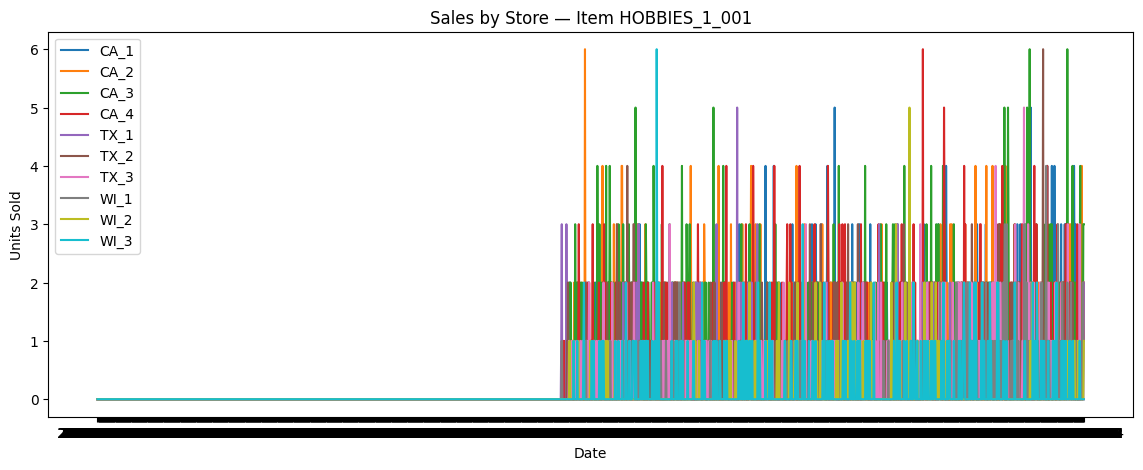

In [27]:
plt.figure(figsize=(14,5))

for store in item_long["store_id"].unique():
    store_data = item_long[item_long["store_id"] == store]
    plt.plot(store_data["date"], store_data["sales"], label=store)

plt.title(f"Sales by Store — Item {ITEM_ID}")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.show()


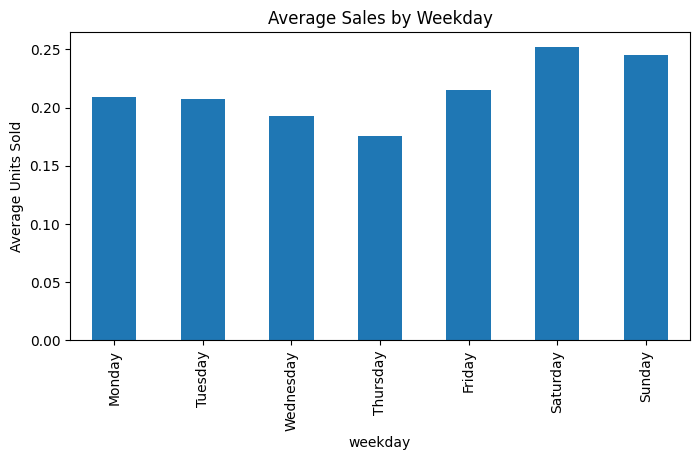

In [29]:
weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

weekday_sales = (
    item_long
    .groupby("weekday")["sales"]
    .mean()
    .reindex(weekday_order)
)

weekday_sales.plot(kind="bar", figsize=(8,4))
plt.title("Average Sales by Weekday")
plt.ylabel("Average Units Sold")
plt.show()



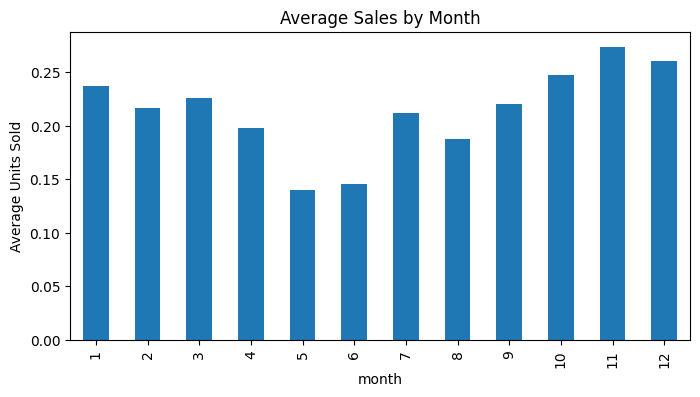

In [30]:
monthly_sales = (
    item_long
    .groupby("month")["sales"]
    .mean()
)

monthly_sales.plot(kind="bar", figsize=(8,4))
plt.title("Average Sales by Month")
plt.ylabel("Average Units Sold")
plt.show()


In [31]:
# Identify last available sales day
d_cols = [c for c in item_sales.columns if c.startswith("d_")]
last_day = int(d_cols[-1].split("_")[1])

# Validation window = last 28 days
val_days = [f"d_{d}" for d in range(last_day - 27, last_day + 1)]

val_days[:5], val_days[-5:]


(['d_1886', 'd_1887', 'd_1888', 'd_1889', 'd_1890'],
 ['d_1909', 'd_1910', 'd_1911', 'd_1912', 'd_1913'])

In [32]:
train_days = [d for d in d_cols if d not in val_days]

train_data = item_sales[train_days]
val_data = item_sales[val_days]

train_data.shape, val_data.shape


((10, 1885), (10, 28))

In [34]:
import numpy as np
# Last observed day before validation
last_train_day = train_days[-1]

naive_pred = item_sales[last_train_day].values.reshape(-1, 1)
naive_pred = np.repeat(naive_pred, repeats=28, axis=1)

naive_pred.shape


(10, 28)

In [35]:
last_7_days = train_days[-7:]

mean7_pred = item_sales[last_7_days].mean(axis=1).values.reshape(-1, 1)
mean7_pred = np.repeat(mean7_pred, repeats=28, axis=1)

mean7_pred.shape


(10, 28)

In [36]:
last_28_days = train_days[-28:]

mean28_pred = item_sales[last_28_days].mean(axis=1).values.reshape(-1, 1)
mean28_pred = np.repeat(mean28_pred, repeats=28, axis=1)

mean28_pred.shape


(10, 28)

In [38]:
from sklearn.metrics import mean_squared_error
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


rmse_naive = rmse(y_true, naive_pred.flatten())
rmse_mean7 = rmse(y_true, mean7_pred.flatten())
rmse_mean28 = rmse(y_true, mean28_pred.flatten())

rmse_naive, rmse_mean7, rmse_mean28


(np.float64(0.9467991188359711),
 np.float64(0.8520683119112371),
 np.float64(0.8044836092494492))

In [39]:
baseline_scores = {
    "Naive (Last Value)": rmse_naive,
    "7-Day Mean": rmse_mean7,
    "28-Day Mean": rmse_mean28
}

pd.Series(baseline_scores).sort_values()


,0
28-Day Mean,0.804484
7-Day Mean,0.852068
Naive (Last Value),0.946799


In [40]:
# Day columns
d_cols = [c for c in item_sales.columns if c.startswith("d_")]

# Melt to long format
df = item_sales.melt(
    id_vars=["id", "item_id", "store_id", "state_id"],
    value_vars=d_cols,
    var_name="d",
    value_name="sales"
)

df.head()


,id,item_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,CA_1,CA,d_1,0
1,HOBBIES_1_001_CA_2_validation,HOBBIES_1_001,CA_2,CA,d_1,0
2,HOBBIES_1_001_CA_3_validation,HOBBIES_1_001,CA_3,CA,d_1,0
3,HOBBIES_1_001_CA_4_validation,HOBBIES_1_001,CA_4,CA,d_1,0
4,HOBBIES_1_001_TX_1_validation,HOBBIES_1_001,TX_1,TX,d_1,0


In [41]:
df = df.merge(
    calendar,
    on="d",
    how="left"
)

df[["d", "date", "weekday", "month", "year", "event_name_1"]].head()


,d,date,weekday,month,year,event_name_1
0,d_1,2011-01-29,Saturday,1,2011,NaN
1,d_1,2011-01-29,Saturday,1,2011,NaN
2,d_1,2011-01-29,Saturday,1,2011,NaN
3,d_1,2011-01-29,Saturday,1,2011,NaN
4,d_1,2011-01-29,Saturday,1,2011,NaN


In [42]:
df = df.merge(
    prices,
    on=["store_id", "item_id", "wm_yr_wk"],
    how="left"
)

df[["store_id", "item_id", "wm_yr_wk", "sell_price"]].head()


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11101,NaN
1,CA_2,HOBBIES_1_001,11101,NaN
2,CA_3,HOBBIES_1_001,11101,NaN
3,CA_4,HOBBIES_1_001,11101,NaN
4,TX_1,HOBBIES_1_001,11101,NaN


In [43]:
df = df.sort_values(["store_id", "date"]).reset_index(drop=True)


In [45]:
LAGS = [7, 28]

for lag in LAGS:
    df[f"lag_{lag}"] = df.groupby("store_id")["sales"].shift(lag)

df[["store_id", "date", "sales", "lag_7", "lag_28"]].head(35)


,store_id,date,sales,lag_7,lag_28
0,CA_1,2011-01-29,0,NaN,NaN
1,CA_1,2011-01-30,0,NaN,NaN
2,CA_1,2011-01-31,0,NaN,NaN
3,CA_1,2011-02-01,0,NaN,NaN
4,CA_1,2011-02-02,0,NaN,NaN
5,CA_1,2011-02-03,0,NaN,NaN
6,CA_1,2011-02-04,0,NaN,NaN
7,CA_1,2011-02-05,0,0.0,NaN
8,CA_1,2011-02-06,0,0.0,NaN
9,CA_1,2011-02-07,0,0.0,NaN


In [46]:
for window in [7, 28]:
    df[f"rmean_{window}"] = (
        df.groupby("store_id")["sales"]
          .shift(1)
          .rolling(window)
          .mean()
    )

df[["sales", "rmean_7", "rmean_28"]].head(35)


,sales,rmean_7,rmean_28
0,0,NaN,NaN
1,0,NaN,NaN
2,0,NaN,NaN
3,0,NaN,NaN
4,0,NaN,NaN
5,0,NaN,NaN
6,0,NaN,NaN
7,0,0.0,NaN
8,0,0.0,NaN
9,0,0.0,NaN


In [47]:
df["is_weekend"] = df["weekday"].isin(["Saturday", "Sunday"]).astype(int)


In [48]:
df_model = df.dropna(subset=["lag_7", "lag_28", "rmean_7", "rmean_28"]).reset_index(drop=True)

df_model.shape


(18850, 25)

In [62]:
df_model["store_id"] = df_model["store_id"].astype("category")


In [63]:
FEATURES = [
    "store_id",
    "lag_1", "lag_7", "lag_14", "lag_28",
    "rmean_7", "rmean_28",
    "sell_price",
    "is_weekend",
    "wday", "month"
]


In [64]:
# Ensure date is datetime and data sorted
df_model = df_model.sort_values(["store_id", "date"]).reset_index(drop=True)

# Add extra lags
for lag in [1, 7, 14, 28]:
    df_model[f"lag_{lag}"] = df_model.groupby("store_id")["sales"].shift(lag)

# Add rolling mean + std (shift(1) avoids leakage)
for window in [7, 28]:
    grp = df_model.groupby("store_id")["sales"]
    df_model[f"rmean_{window}"] = grp.shift(1).rolling(window).mean()
    df_model[f"rstd_{window}"]  = grp.shift(1).rolling(window).std()

# Drop rows that still have NA from new features
df_model = df_model.dropna(subset=["lag_28", "rmean_28", "rstd_28"]).reset_index(drop=True)


/tmp/ipython-input-3427800098.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_model[f"lag_{lag}"] = df_model.groupby("store_id")["sales"].shift(lag)
/tmp/ipython-input-3427800098.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_model[f"lag_{lag}"] = df_model.groupby("store_id")["sales"].shift(lag)
/tmp/ipython-input-3427800098.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_model[f"lag_{lag}"] = df_mo

In [65]:
df_model["date"] = pd.to_datetime(df_model["date"])

val_start_date = df_model["date"].max() - pd.Timedelta(days=27)
train_df = df_model[df_model["date"] < val_start_date]
val_df   = df_model[df_model["date"] >= val_start_date]

X_train, y_train = train_df[FEATURES], train_df["sales"]
X_val, y_val     = val_df[FEATURES], val_df["sales"]


In [56]:
!pip install lightgbm


In [66]:
import lightgbm as lgb

model = lgb.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.03,
    num_leaves=128,
    min_data_in_leaf=50,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="rmse"
)

pred = model.predict(X_val)
rmse_lgb = np.sqrt(((y_val - pred) ** 2).mean())
rmse_lgb


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 121
[LightGBM] [Info] Number of data points in the train set: 18290, number of used features: 11
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Start training from score 0.215856
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


np.float64(0.8701109349797567)

In [68]:
# baseline: 28-day mean per store
last_28 = [c for c in item_sales.columns if c.startswith("d_")][-28:]
baseline_28 = item_sales[last_28].mean(axis=1).values  # per store

# align baseline to val rows (repeat each store baseline for each day in val)
baseline_val = np.repeat(baseline_28, repeats=28)

# blend
alpha = 0.5
blend = alpha * pred + (1 - alpha) * baseline_val

rmse_blend = np.sqrt(((y_val.values - blend) ** 2).mean())
rmse_lgb, rmse_blend


(np.float64(0.8701109349797567), np.float64(0.800759041762299))

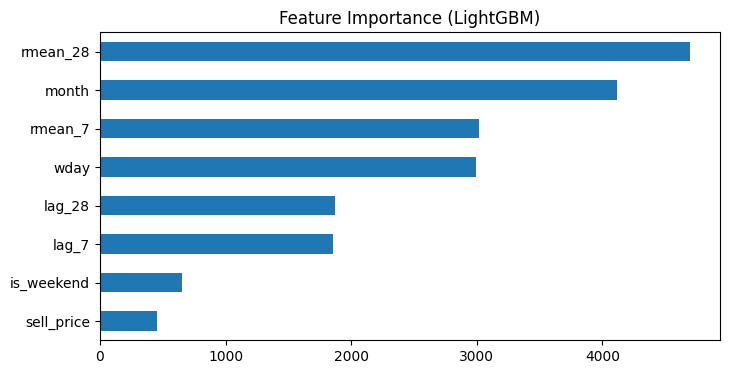

In [61]:
importances = pd.Series(
    model.feature_importances_,
    index=FEATURES
).sort_values()

importances.plot(kind="barh", figsize=(8,4))
plt.title("Feature Importance (LightGBM)")
plt.show()


In [69]:
calendar["date"] = pd.to_datetime(calendar["date"])

# Sales ends at d_1913
last_day = 1913
future_days = [f"d_{d}" for d in range(last_day + 1, last_day + 29)]

future_cal = calendar[calendar["d"].isin(future_days)].copy()
future_cal = future_cal.sort_values("date")

future_cal[["d","date","weekday","wday","month","year","event_name_1"]].head()


,d,date,weekday,wday,month,year,event_name_1
1913,d_1914,2016-04-25,Monday,3,4,2016,NaN
1914,d_1915,2016-04-26,Tuesday,4,4,2016,NaN
1915,d_1916,2016-04-27,Wednesday,5,4,2016,NaN
1916,d_1917,2016-04-28,Thursday,6,4,2016,NaN
1917,d_1918,2016-04-29,Friday,7,4,2016,NaN


In [70]:
# Make sure df has datetime date
df["date"] = pd.to_datetime(df["date"])

# Keep only this item's data (all stores) and the historical portion up to d_1913
hist = df[df["d"].isin([f"d_{i}" for i in range(1, last_day+1)])].copy()
hist = hist.sort_values(["store_id","date"])

hist[["store_id","date","sales","sell_price","wday","month"]].head()


,store_id,date,sales,sell_price,wday,month
0,CA_1,2011-01-29,0,NaN,1,1
1,CA_1,2011-01-30,0,NaN,2,1
2,CA_1,2011-01-31,0,NaN,3,1
3,CA_1,2011-02-01,0,NaN,4,2
4,CA_1,2011-02-02,0,NaN,5,2


In [71]:
stores = hist["store_id"].unique()

future = (
    future_cal.assign(key=1)
    .merge(pd.DataFrame({"store_id": stores, "key": 1}), on="key")
    .drop(columns=["key"])
)

# Add identifiers for merge with prices
future["item_id"] = ITEM_ID
future["state_id"] = future["store_id"].str.split("_").str[0]  # CA / TX / WI

# Merge future prices using wm_yr_wk + store_id + item_id
future = future.merge(
    prices,
    on=["store_id", "item_id", "wm_yr_wk"],
    how="left"
)

# weekend flag
future["is_weekend"] = future["weekday"].isin(["Saturday","Sunday"]).astype(int)

future[["store_id","date","wm_yr_wk","sell_price","weekday","is_weekend"]].head()


,store_id,date,wm_yr_wk,sell_price,weekday,is_weekend
0,CA_1,2016-04-25,11613,8.38,Monday,0
1,CA_2,2016-04-25,11613,8.38,Monday,0
2,CA_3,2016-04-25,11613,8.38,Monday,0
3,CA_4,2016-04-25,11613,8.38,Monday,0
4,TX_1,2016-04-25,11613,8.26,Monday,0


In [74]:
# ---- Step 6 forecasting loop (UPDATED to fix categorical mismatch) ----

alpha = 0.5  # same blend weight you used

# IMPORTANT: store categories must match training exactly (fixes LightGBM error)
# Make sure X_train exists and store_id was set to category during Step 5
store_cats = X_train["store_id"].cat.categories

# We'll keep a copy of historical sales per store that we can extend with predictions
hist_series = {}
for store in stores:
    s = hist[hist["store_id"] == store].set_index("date")["sales"].sort_index()
    hist_series[store] = s.copy()

pred_rows = []  # store predictions here

for date_i in future_cal["date"].tolist():
    day_rows = future[future["date"] == date_i].copy()

    # For each store, compute lag/rolling features from the evolving history
    lag_1_list, lag_7_list, lag_14_list, lag_28_list = [], [], [], []
    rmean_7_list, rmean_28_list = [], []
    rstd_7_list, rstd_28_list = [], []

    for store in day_rows["store_id"].tolist():
        series = hist_series[store]

        # lags
        lag_1  = series.iloc[-1] if len(series) >= 1 else np.nan
        lag_7  = series.iloc[-7] if len(series) >= 7 else np.nan
        lag_14 = series.iloc[-14] if len(series) >= 14 else np.nan
        lag_28 = series.iloc[-28] if len(series) >= 28 else np.nan

        # rolling (use past only)
        rmean_7  = series.iloc[-7:].mean() if len(series) >= 7 else np.nan
        rmean_28 = series.iloc[-28:].mean() if len(series) >= 28 else np.nan
        rstd_7   = series.iloc[-7:].std() if len(series) >= 7 else np.nan
        rstd_28  = series.iloc[-28:].std() if len(series) >= 28 else np.nan

        lag_1_list.append(lag_1)
        lag_7_list.append(lag_7)
        lag_14_list.append(lag_14)
        lag_28_list.append(lag_28)
        rmean_7_list.append(rmean_7)
        rmean_28_list.append(rmean_28)
        rstd_7_list.append(rstd_7)
        rstd_28_list.append(rstd_28)

    # attach features
    day_rows["lag_1"] = lag_1_list
    day_rows["lag_7"] = lag_7_list
    day_rows["lag_14"] = lag_14_list
    day_rows["lag_28"] = lag_28_list
    day_rows["rmean_7"] = rmean_7_list
    day_rows["rmean_28"] = rmean_28_list
    day_rows["rstd_7"] = rstd_7_list
    day_rows["rstd_28"] = rstd_28_list

    # OPTIONAL (but recommended): handle missing future prices after merge
    # (if a store-week price is missing, forward/back fill within this day slice)
    if "sell_price" in day_rows.columns:
        day_rows["sell_price"] = day_rows.groupby("store_id")["sell_price"].ffill().bfill()

    # IMPORTANT: ensure store_id categorical matches training categories
    day_rows["store_id"] = pd.Categorical(day_rows["store_id"], categories=store_cats)

    # Prepare model input
    X_day = day_rows[FEATURES].copy()

    # LightGBM prediction
    ml_pred = model.predict(X_day)

    # Baseline per store: use last 28-day mean from current history
    base_pred = []
    for store in day_rows["store_id"].astype(str).tolist():  # ensure we can index hist_series
        series = hist_series[store]
        base_pred.append(series.iloc[-28:].mean() if len(series) >= 28 else series.mean())
    base_pred = np.array(base_pred)

    # Blend
    final_pred = alpha * ml_pred + (1 - alpha) * base_pred
    final_pred = np.clip(final_pred, 0, None)  # sales can't be negative

    # Save predictions and update history
    out_rows = day_rows.copy()
    out_rows["pred"] = final_pred
    pred_rows.append(out_rows[["store_id", "date", "pred"]])

    # Update each store's history with today's prediction (recursive forecasting)
    for store, pred_val in zip(day_rows["store_id"].astype(str).tolist(), final_pred):
        hist_series[store] = pd.concat(
            [hist_series[store], pd.Series([pred_val], index=[date_i])]
        )


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min

In [75]:
pred_df = pd.concat(pred_rows).sort_values(["store_id", "date"]).reset_index(drop=True)

# horizon index 1..28 per store
pred_df["h"] = pred_df.groupby("store_id").cumcount() + 1

# Pivot to wide (store rows × F1..F28)
pred_wide = pred_df.pivot(index="store_id", columns="h", values="pred")
pred_wide.columns = [f"F{i}" for i in range(1, 29)]
pred_wide = pred_wide.reset_index()

pred_wide.head()


/tmp/ipython-input-3300600839.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pred_df["h"] = pred_df.groupby("store_id").cumcount() + 1


,store_id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,CA_1,0.420616,0.616848,0.761246,0.960172,1.058330,0.832906,0.973896,0.919516,0.946777,...,0.886534,1.167089,0.533586,0.661968,1.030775,0.871860,0.728490,0.703844,1.071459,0.570970
1,CA_2,0.612639,0.316674,0.203091,0.572035,0.538212,0.622131,0.468531,0.490252,0.648157,...,0.261630,0.922074,0.508531,0.388580,0.438944,0.433340,0.170314,0.156708,0.366320,0.236089
2,CA_3,0.809581,1.038560,0.907887,0.422515,0.864973,0.801147,0.878980,0.771043,1.057042,...,0.900604,0.937135,0.720091,0.695894,0.953887,0.890912,0.561305,0.834153,1.055985,0.946397
3,CA_4,0.591228,0.472275,0.339464,0.479006,0.415993,0.836129,0.363041,0.336740,0.500955,...,0.480107,0.263117,0.202762,0.236941,0.407655,0.322070,0.431649,0.468398,0.718093,0.652168
4,TX_1,0.249737,0.416331,0.415051,0.366087,0.535329,0.186919,0.041426,0.114817,0.470463,...,0.386552,0.343808,0.185010,0.103350,0.216043,0.261739,0.238284,0.381816,0.373747,0.275738


In [76]:
print("Any NaNs in predictions?", pred_wide.isna().any().any())
print("Min prediction:", pred_wide[[f"F{i}" for i in range(1,29)]].min().min())
print("Max prediction:", pred_wide[[f"F{i}" for i in range(1,29)]].max().max())

pred_df.head()


Any NaNs in predictions? False
Min prediction: 0.0
Max prediction: 1.167088827813732


,store_id,date,pred,h
0,CA_1,2016-04-25,0.420616,1
1,CA_1,2016-04-26,0.616848,2
2,CA_1,2016-04-27,0.761246,3
3,CA_1,2016-04-28,0.960172,4
4,CA_1,2016-04-29,1.058330,5


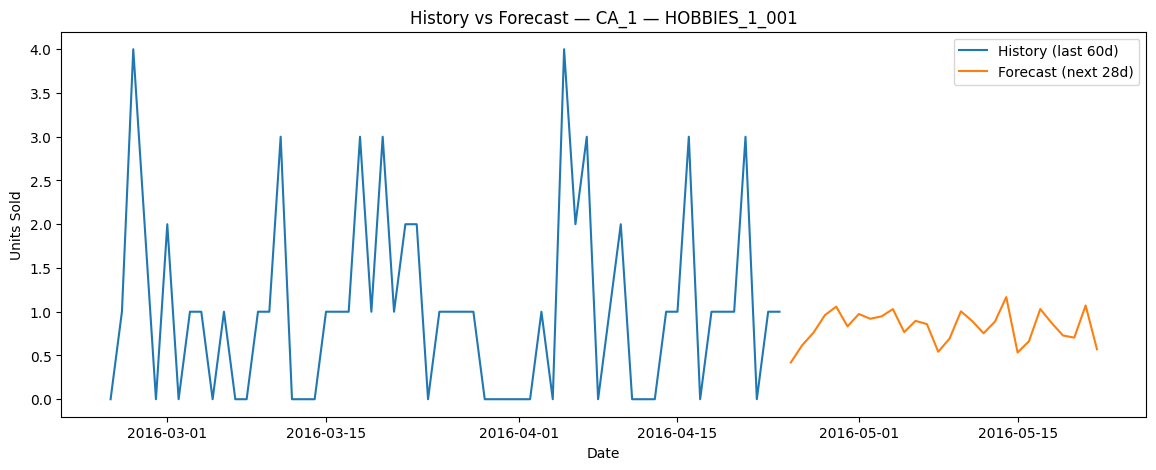

In [77]:
# pick one store to visualize
store0 = pred_df["store_id"].iloc[0]

# last 60 days of actual history for that store
hist_store = hist[hist["store_id"] == store0].sort_values("date").tail(60)

# predictions for that store
pred_store = pred_df[pred_df["store_id"] == store0].sort_values("date")

plt.figure(figsize=(14,5))
plt.plot(hist_store["date"], hist_store["sales"], label="History (last 60d)")
plt.plot(pred_store["date"], pred_store["pred"], label="Forecast (next 28d)")
plt.title(f"History vs Forecast — {store0} — {ITEM_ID}")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.show()
